<a href="https://colab.research.google.com/github/kashishthakur26/Tensorflow-learning/blob/raw-code-tf/transfer_learning_using_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing helper functions


In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-06-02 03:57:03.772424


In [2]:
! nvidia-smi

/bin/bash: nvidia-smi: command not found


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-06-02 03:57:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-02 03:57:04 (126 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-06-02 03:57:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   168MB/s    in 1.0s    

2023-06-02 03:57:12 (168 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [6]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224,224) 
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE
                                                                            )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building a transfer learning model using the keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order.

But the functional API Gives us more flexibility with our moels.

In [9]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

x = base_model(inputs)
print(f"shape after passing inputs through base model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

outputs = tf.keras.layers.Dense(10 , activation="softmax" , name="output_layer")(x)

model_0 = tf.keras.Model(inputs , outputs)



16705208/16705208 [==============================] - 0s 0us/step
shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [10]:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

history_O = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="food_10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/food_10_percent_feature_extraction/20230602-035720
Epoch 1/5
24/24 [==============================] - 74s 3s/step - loss: 1.8995 - accuracy: 0.4120 - val_loss: 1.3083 - val_accuracy: 0.7352
Epoch 2/5
24/24 [==============================] - 82s 3s/step - loss: 1.0984 - accuracy: 0.7773 - val_loss: 0.8805 - val_accuracy: 0.8010
Epoch 3/5
24/24 [==============================] - 78s 3s/step - loss: 0.7803 - accuracy: 0.8427 - val_loss: 0.7251 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 65s 3s/step - loss: 0.6328 - accuracy: 0.8680 - val_loss: 0.6159 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 70s 3s/step - loss: 0.5303 - accuracy: 0.8947 - val_loss: 0.5524 - val_accuracy: 0.8487


In [11]:
model_0.evaluate(test_data)

79/79 [==============================] - 141s 2s/step - loss: 0.5486 - accuracy: 0.8584


[0.5486041307449341, 0.8583999872207642]

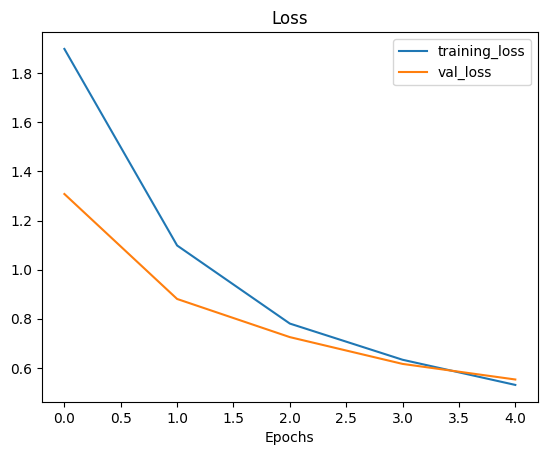

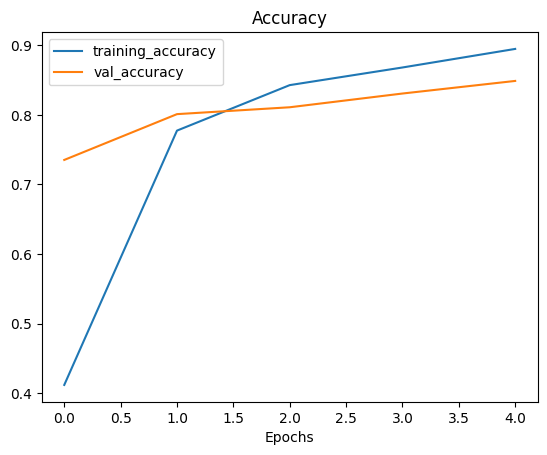

In [12]:
plot_loss_curves(history_O)

## Running a series of transfer learning experiments

1. model-1 : use feature extraction trasnfer learning with 1% of the training data with augmentation
2. model-2 : use feature extraction transfer learning with 10% of the training with data augmnetation
3. model-3 : use fine-tuning transfer learning on 10% of the training data with data augmentation
4. model-4 : use fine-tuning transfer learning on 100% of the training data with data augmentation

In [13]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-06-02 04:06:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   149MB/s    in 0.9s    

2023-06-02 04:06:06 (149 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [14]:
# creating training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [15]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [16]:
IMG_SIZE=(224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size=32
                                                                           )

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size=32
                                                                           )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model
to add data augmentation right into our models, we can use the layers inside:
* 'tf.keras.layers.experimental.preprocessing()'

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#data augmentation

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
],name="data_augmentation")

(-0.5, 556.5, 420.5, -0.5)

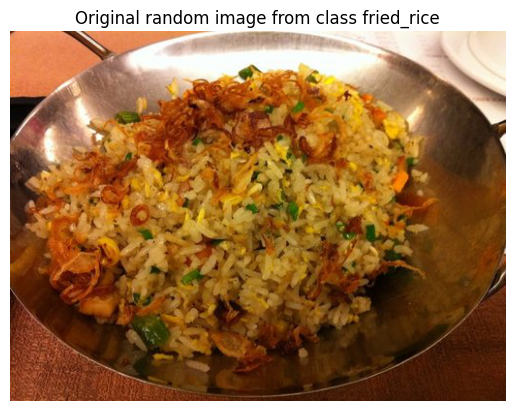

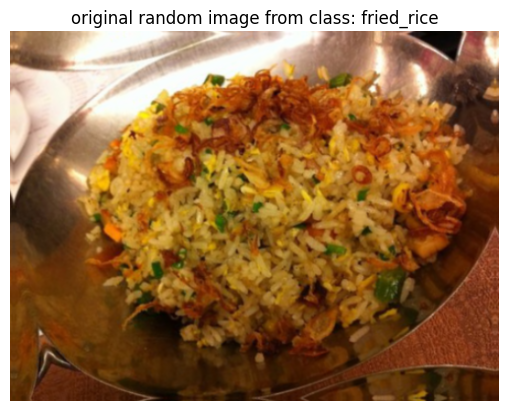

In [18]:
# Visualize our augmented data

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image

#read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

#Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img , axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"original random image from class: {target_class}")
plt.axis(False)



In [19]:
## Model 1: feature extraction transfer learning on 1% of the data with data augmentation

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=input_shape , name="input_layer")
x = data_augmentation(inputs)
x = base_model(x , training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs= layers.Dense(10 , activation="softmax" , name="output_layer")(x)

model_1 = keras.Model(inputs ,outputs)

# Compile the model

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230602-040615
Epoch 1/5
79/79 [==============================] - 175s 2s/step - loss: 1.3555 - accuracy: 0.6356 - val_loss: 0.6761 - val_accuracy: 0.8503
Epoch 2/5
79/79 [==============================] - 176s 2s/step - loss: 0.6892 - accuracy: 0.8184 - val_loss: 0.4713 - val_accuracy: 0.8717
Epoch 3/5
79/79 [==============================] - 174s 2s/step - loss: 0.5428 - accuracy: 0.8564 - val_loss: 0.3967 - val_accuracy: 0.8832
Epoch 4/5
79/79 [==============================] - 173s 2s/step - loss: 0.4674 - accuracy: 0.8668 - val_loss: 0.3370 - val_accuracy: 0.9062
Epoch 5/5
79/79 [==============================] - 176s 2s/step - loss: 0.4273 - accuracy: 0.8756 - val_loss: 0.3337 - val_accuracy: 0.8997


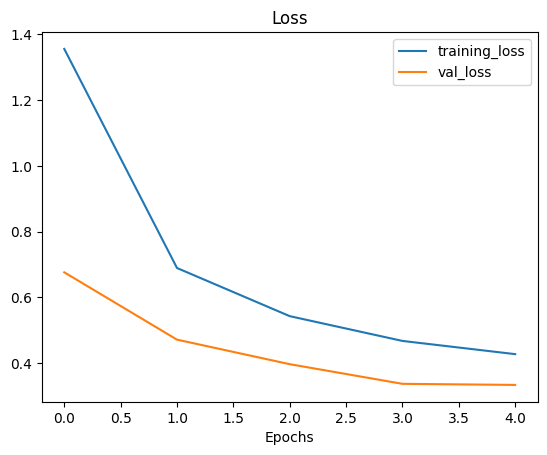

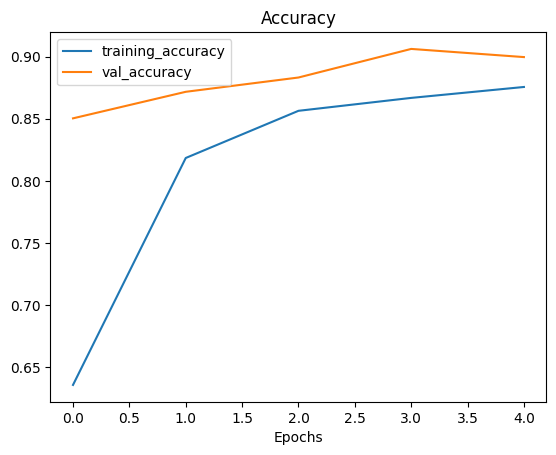

In [20]:
 plot_loss_curves(history_1_percent)

## Model 2 : Feature extraction transfer learning model with 10 percent

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"
